In [125]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [126]:
#df = pd.read_csv('data_preprocessed.csv')
#df = pd.read_csv('tfidf_df.csv')
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = np.ravel(pd.read_csv('y_train.csv'))
y_test = np.ravel(pd.read_csv('y_test.csv'))

In [127]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [128]:
y_pred = nb_classifier.predict(X_test)

In [129]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.30302552789158527


In [130]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       false       0.38      0.56      0.45      1733
    halftrue       0.23      0.29      0.26      1061
 mostlyfalse       0.20      0.16      0.18       982
  mostlytrue       0.25      0.26      0.26      1009
   pantsfire       0.39      0.17      0.24       816
        true       0.27      0.10      0.15       745

    accuracy                           0.30      6346
   macro avg       0.29      0.26      0.26      6346
weighted avg       0.30      0.30      0.28      6346



In [131]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print scores
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.30302552789158527
Precision: 0.2885145748709359
Recall: 0.25849290718577456
F1-score: 0.25635883166301215


Model Tuning using RandomSearchCV

In [132]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import uniform

# Define the parameter distributions
param_dist = {
    'alpha': uniform(0, 2),  # Example distribution for alpha
    'fit_prior': [True, False]  # Example values for fit_prior
}

# Initialize MultinomialNB classifier
classifier = MultinomialNB()
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'roc_auc_ovr': make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True),
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=classifier, 
                                   param_distributions=param_dist, 
                                   n_iter=10, 
                                   cv=5, 
                                   scoring=scoring, 
                                   refit='roc_auc_ovr',
                                   random_state=42)
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the best model
y_pred_proba = best_model.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("Score:", score)


c:\Users\annma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best Hyperparameters: {'alpha': 1.6648852816008435, 'fit_prior': False}
Score: 0.6622191331166353


In [133]:
nb_classifier = MultinomialNB(**best_params)
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.6648852816008435, fit_prior=False)

In [134]:
y_pred = nb_classifier.predict(X_test)

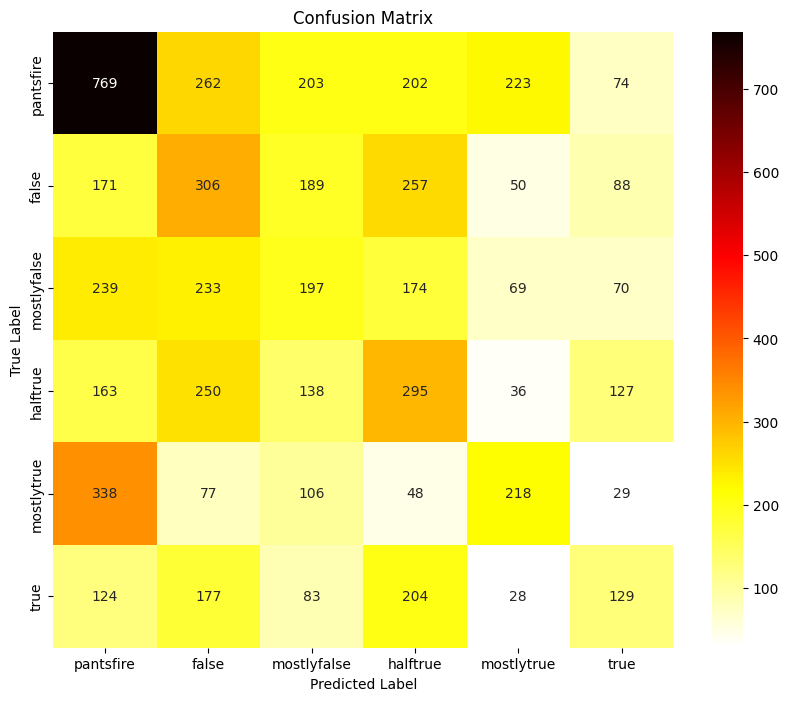

In [135]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
classes = ['pantsfire', 'false', 'mostlyfalse', 'halftrue', 'mostlytrue', 'true']

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='hot_r', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [148]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = nb_classifier.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
# Compute ROC curve and ROC area for each class
for i in range(len(classes)):
    # Convert class labels to binary labels (1 for the current class, 0 for the rest)
    binary_labels = [1 if label == classes[i] else 0 for label in y_test]

    # Compute ROC curve and AUC for the current class
    fpr[classes[i]], tpr[classes[i]], _ = roc_curve(binary_labels, y_score[:, i])
    roc_auc[classes[i]] = auc(fpr[classes[i]], tpr[classes[i]])

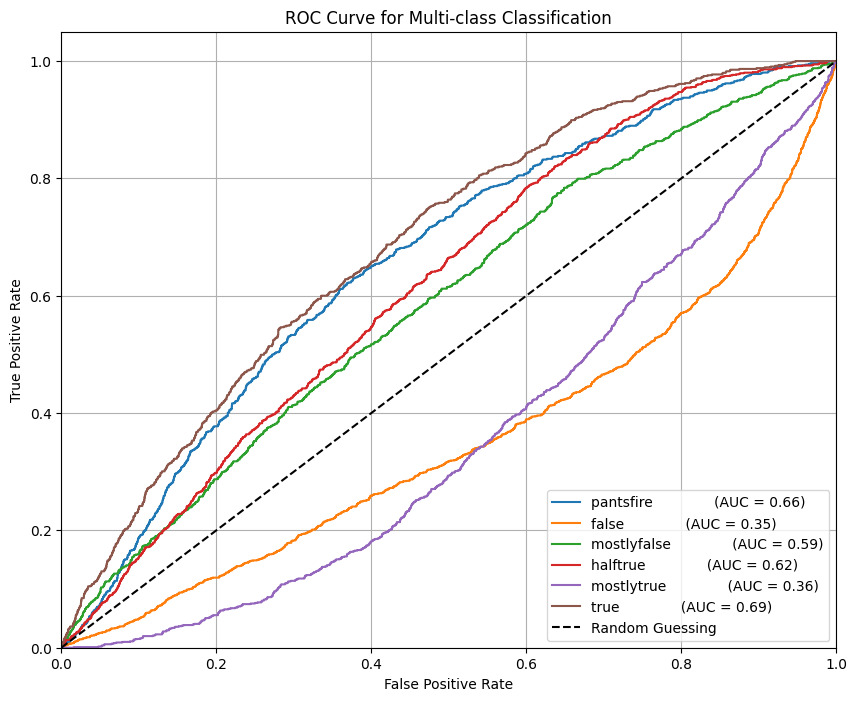

In [150]:
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(fpr[classes[i]], tpr[classes[i]], label=f'{classes[i]} \
             (AUC = {roc_auc[classes[i]]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [137]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       false       0.43      0.44      0.43      1733
    halftrue       0.23      0.29      0.26      1061
 mostlyfalse       0.22      0.20      0.21       982
  mostlytrue       0.25      0.29      0.27      1009
   pantsfire       0.35      0.27      0.30       816
        true       0.25      0.17      0.20       745

    accuracy                           0.30      6346
   macro avg       0.29      0.28      0.28      6346
weighted avg       0.30      0.30      0.30      6346



Get the average metrics for the multiple labels using macro

In [145]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

# Print scores
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC score: {roc_auc}")

Accuracy: 0.3016073116924047
Precision: 0.28744977012275
Recall: 0.2775728747755259
F1-score: 0.27963796145102343
ROC-AUC score: 0.6622191331166353


Feature Importance

In [139]:
# Get the conditional probabilities of each feature given each class
feature_probs = np.exp(nb_classifier.feature_log_prob_)
feature_importance = np.max(feature_probs, axis=0)
sorted_indices = np.argsort(feature_importance)[::-1]

# Print the feature importance scores and corresponding feature names
for i, idx in enumerate(sorted_indices):
    print(f"Feature {i+1}: Importance = {feature_importance[idx]:.4f}, Name = {X_train.columns[idx]}")


Feature 1: Importance = 0.0767, Name = statement_source
Feature 2: Importance = 0.0687, Name = factchecker
Feature 3: Importance = 0.0423, Name = statement_originator
Feature 4: Importance = 0.0064, Name = state
Feature 5: Importance = 0.0052, Name = trump
Feature 6: Importance = 0.0051, Name = year
Feature 7: Importance = 0.0050, Name = percent
Feature 8: Importance = 0.0040, Name = tax
Feature 9: Importance = 0.0039, Name = people
Feature 10: Importance = 0.0036, Name = covid
Feature 11: Importance = 0.0034, Name = million
Feature 12: Importance = 0.0032, Name = show
Feature 13: Importance = 0.0030, Name = care
Feature 14: Importance = 0.0029, Name = biden
Feature 15: Importance = 0.0028, Name = health
Feature 16: Importance = 0.0027, Name = barack
Feature 17: Importance = 0.0027, Name = american
Feature 18: Importance = 0.0027, Name = vote
Feature 19: Importance = 0.0027, Name = country
Feature 20: Importance = 0.0027, Name = cut
Feature 21: Importance = 0.0026, Name = donald
Featur